In [1]:
import apache_beam as beam
import numpy as np
import pandas as pd
import xarray_beam as xbeam
import xarray as xr
import tqdm


In [2]:
ds, chunks = xbeam.open_zarr('gs://weatherbench2/datasets/era5/1959-2023_01_10-full_37-1h-512x256_equiangular_conservative.zarr')

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

learning_rate = 1e-3
training_epochs = 3
batch_size = 2

In [4]:
import gc
gc.collect()

0

In [5]:
variables_without_level = [var for var in ds.data_vars if 'level' not in ds[var].dims]
variables_with_level = [var for var in ds.data_vars if 'level' in ds[var].dims]
key = list(ds.keys())

print(ds[variables_without_level])

<xarray.Dataset>
Dimensions:                                           (time: 561264,
                                                       longitude: 512,
                                                       latitude: 256)
Coordinates:
  * latitude                                          (latitude) float64 -89....
  * longitude                                         (longitude) float64 0.0...
  * time                                              (time) datetime64[ns] 1...
Data variables: (12/41)
    10m_u_component_of_wind                           (time, longitude, latitude) float32 ...
    10m_v_component_of_wind                           (time, longitude, latitude) float32 ...
    2m_dewpoint_temperature                           (time, longitude, latitude) float32 ...
    2m_temperature                                    (time, longitude, latitude) float32 ...
    angle_of_sub_gridscale_orography                  (longitude, latitude) float32 ...
    anisotropy_of_sub_gridsca

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split # 훈련 데이터셋과 테스트 데이터셋을 분할할 때 사용한다.
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from datetime import datetime

def total_days_until_month(dt):
    days_in_month = [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

    total_days = sum(days_in_month[:dt.month])  # 현재 월 전까지의 일 수 합

    # 윤년인 경우 2월의 일 수를 29일로 수정
    if dt.year % 4 == 0 and (dt.year % 100 != 0 or dt.year % 400 == 0):
        days_in_month[2] = 29

    total_days += dt.day  # 현재 월의 일 수 더하기

    return total_days

def getHour(dt_object: datetime):
    day = total_days_until_month(dt_object) - 1
    hour = dt_object.hour + day*24
    return hour

def normalize_data(data):
    # 최솟값을 0으로 조정
    min_value = data.min()
    
    # 정규화
    normalized_data = (data - min_value) / (data.max() - min_value)
    
    return normalized_data

class CustomDataset(Dataset):
    def __init__(self, data_array, time_seq, transform=None):
        self.data_array = data_array
        self.transform = transform
        self.time_seq = time_seq

    def __len__(self):
        return len(self.data_array)

    def __getitem__(self, idx):
        sample = self.data_array[idx]
        if self.transform:
            sample = self.transform(sample)
        return torch.tensor(sample, dtype=torch.float32), self.time_seq[idx]


def replace_nan_with_zero(arr):
    # NaN 위치 찾기
    nan_indices = np.isnan(arr)

    # NaN 값을 주변 값의 평균으로 대체
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            if nan_indices[i, j]:
                # 상하좌우 값 가져오기
                neighbors = []

                if i > 0:
                    neighbors.append(arr[i-1, j])  # 위
                if i < arr.shape[0] - 1:
                    neighbors.append(arr[i+1, j])  # 아래
                if j > 0:
                    neighbors.append(arr[i, j-1])  # 왼쪽
                if j < arr.shape[1] - 1:
                    neighbors.append(arr[i, j+1])  # 오른쪽

                # NaN 값을 주변 값의 평균으로 대체
                arr[i, j] = np.nanmean(neighbors)

    return arr


def load_data_without_level(ds:xr.Dataset, keys, start_date, n_days, batch_size=1):
    detaset = []
    end_date = start_date + pd.DateOffset(days=n_days)
    time_seq = [getHour(dt_object) for dt_object in pd.date_range(start=start_date, end=end_date, freq='H') ]

    for key in tqdm.tqdm(keys, desc="변수별 데이터셋 분리"):
        arr = ds[key]
        if 'time' in arr.dims:
            arr = arr.sel(time=slice(start_date, end_date))
            arr = arr.to_numpy()
            arr = normalize_data(arr)
            has_nan = np.isnan(arr).any()
            if has_nan:
                nan_indices = np.isnan(arr)
                arr[nan_indices] = 0
            detaset.append(arr)


    #(시간(배치), 변수 개수, 높이, 너비)
    detaset = np.array(detaset).swapaxes(0, 1)
    print(detaset)

    #(시간(배치), 변수 개수, 채널, 높이, 너비)
    detaset = np.expand_dims(detaset, axis=2)
    print(detaset)
    print(time_seq)


    print("데이터셋 분리")
    train_dataset, valid_dataset = train_test_split(detaset, test_size=0.15, random_state=0)
    # Use a custom dataset class with proper transformations

    train_data = CustomDataset(train_dataset, time_seq=time_seq)
    valid_data = CustomDataset(valid_dataset, time_seq=time_seq)

    print("커스텀 데이터셋 완료")
    # Use DataLoader with the custom dataset
    train_data_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
    valid_data_loader = DataLoader(dataset=valid_data, batch_size=batch_size, shuffle=True)
    print("데이터 로더")
    return train_data_loader, valid_data_loader

train_data_loader, valid_data_loader = load_data_without_level(ds, variables_without_level, pd.to_datetime('2022-01-01'), 15)
print(len(train_data_loader))

변수별 데이터셋 분리: 100%|██████████| 41/41 [07:06<00:00, 10.40s/it]


[[[[5.1824945e-01 5.0655377e-01 4.9116361e-01 ... 4.4355088e-01
    4.5575976e-01 4.6147999e-01]
   [5.1950973e-01 5.0818074e-01 4.9267545e-01 ... 4.4402993e-01
    4.5638523e-01 4.6203920e-01]
   [5.2092212e-01 5.0977862e-01 4.9418566e-01 ... 4.4451070e-01
    4.5699748e-01 4.6267796e-01]
   ...
   [5.1441127e-01 5.0147218e-01 4.8694316e-01 ... 4.4215715e-01
    4.5361772e-01 4.5969632e-01]
   [5.1572144e-01 5.0315827e-01 4.8834142e-01 ... 4.4261956e-01
    4.5432809e-01 4.6031004e-01]
   [5.1702714e-01 5.0484622e-01 4.8972866e-01 ... 4.4307965e-01
    4.5504421e-01 4.6092826e-01]]

  [[3.5234922e-01 3.4454867e-01 3.4182948e-01 ... 5.5124998e-01
    5.6567478e-01 5.6216407e-01]
   [3.5233077e-01 3.4446317e-01 3.4162590e-01 ... 5.5114156e-01
    5.6568837e-01 5.6238222e-01]
   [3.5235700e-01 3.4445456e-01 3.4145898e-01 ... 5.5100238e-01
    5.6566697e-01 5.6264150e-01]
   ...
   [3.5369858e-01 3.4644485e-01 3.4325641e-01 ... 5.5072570e-01
    5.6463790e-01 5.6096107e-01]
   [3.5321775e

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
%load_ext autoreload
%autoreload 2
from UNet import UNet
from torchviz import make_dot
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

device = torch.device('mps' if torch.cuda.is_available else 'cpu')

model = UNet(n_channels=1, n_classes=1).to(device)

criterion = nn.BCELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [8]:
for i, (batch_X, k) in enumerate(train_data_loader):
    print(batch_X.shape)

torch.Size([1, 28, 1, 512, 256])
torch.Size([1, 28, 1, 512, 256])
torch.Size([1, 28, 1, 512, 256])
torch.Size([1, 28, 1, 512, 256])
torch.Size([1, 28, 1, 512, 256])
torch.Size([1, 28, 1, 512, 256])
torch.Size([1, 28, 1, 512, 256])
torch.Size([1, 28, 1, 512, 256])
torch.Size([1, 28, 1, 512, 256])
torch.Size([1, 28, 1, 512, 256])
torch.Size([1, 28, 1, 512, 256])
torch.Size([1, 28, 1, 512, 256])
torch.Size([1, 28, 1, 512, 256])
torch.Size([1, 28, 1, 512, 256])
torch.Size([1, 28, 1, 512, 256])
torch.Size([1, 28, 1, 512, 256])
torch.Size([1, 28, 1, 512, 256])
torch.Size([1, 28, 1, 512, 256])
torch.Size([1, 28, 1, 512, 256])
torch.Size([1, 28, 1, 512, 256])
torch.Size([1, 28, 1, 512, 256])
torch.Size([1, 28, 1, 512, 256])
torch.Size([1, 28, 1, 512, 256])
torch.Size([1, 28, 1, 512, 256])
torch.Size([1, 28, 1, 512, 256])
torch.Size([1, 28, 1, 512, 256])
torch.Size([1, 28, 1, 512, 256])
torch.Size([1, 28, 1, 512, 256])
torch.Size([1, 28, 1, 512, 256])
torch.Size([1, 28, 1, 512, 256])
torch.Size

In [9]:
def acc_fn(y_pred, y_true):
    accuracy = torch.eq(y_pred, y_true).sum().item()/len(y_pred)
    return accuracy

def evaluate(model, valid_data_loader, criterion, device):
  val_loss = 0
  val_total = 0
  val_accu = 0
  val_total_pix = 0

  model.eval()

  with torch.no_grad():
    for batch_X, time in valid_data_loader:
      batch_X = batch_X.to(device).squeeze(0)
      batch_X = batch_X.view(7, -1, 1, batch_X.size(2), batch_X.size(3))
      for x in batch_X:
        output = model(x)
        loss = criterion(output, x)
        _, predicted = torch.max(output, 1)
        val_loss += loss.item()
        val_total += x.size(0)
        val_accu += acc_fn(predicted, x)
        val_total_pix += x.nelement()

  val_loss /= val_total
  val_accu /= val_total_pix

  return val_loss, val_accu

In [10]:
def train(model, train_data_loader, valid_data_loader, criterion, device, max_epoch=3):
    best_val_loss = float('inf')

    for epoch in range(max_epoch):
        train_loss = 0
        train_total = 0
        train_accu = 0
        train_total_pix = 0

        for i, (batch_X, time) in enumerate(train_data_loader):
            batch_X = batch_X.to(device).squeeze(0)
            batch_X = batch_X.view(7, -1, 1, batch_X.size(2), batch_X.size(3))
            for x in batch_X:
                optimizer.zero_grad()
                output = model(x)
                
                loss = criterion(output, x)
                loss.backward()
                optimizer.step()
                _, predicted = torch.max(output, 1)
    
                train_loss += loss.item()
                train_total += x.size(0)
                train_accu += acc_fn(predicted, x)
                train_total_pix += x.nelement()

                writer.add_scalar("Loss/train", loss, i)
                writer.add_scalar("Loss/accuracy", acc_fn(predicted, x) / x.nelement(), i)

            if i % 100 == 0:
                print(f"{i}번 학습됨")

        train_loss /= train_total

        val_loss, val_accu = evaluate(model, valid_data_loader, criterion, device)

        print(f'Epoch {epoch+1}/{max_epoch}:')
        print(f'Train Loss: {train_loss: .4f}')
        print(f'Validation Loss: {val_loss: .4f}')
        print(f'Validation Accuracy: {val_accu: .4f}')

        if val_loss < best_val_loss:
            print(f'Validation loss imporved {best_val_loss: .4f} -> {val_loss : .4f}, 체크포인트를 저장합니다.')
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model_checkpoint.pth')

        writer.close()
    

In [11]:
train(model, train_data_loader, valid_data_loader, criterion, device)

0번 학습됨


KeyboardInterrupt: 

In [ ]:
model.load_state_dict(torch.load('best_model_checkpoint.pth'))

[autoreload of google.protobuf.descriptor failed: Traceback (most recent call last):
  File "/workspace/weather/venv/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/workspace/weather/venv/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/workspace/weather/venv/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/workspace/weather/venv/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 365, in update_class
    update_instances(old, new)
  File "/workspace/weather/venv/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 323, in update_instances
    object.__setattr__(ref, "__class__", new)
TypeError: can't apply this __setattr__ to DescriptorMetaclass object
]
[autoreload of google.protobuf.wrappers_pb2 failed: Traceba

<All keys matched successfully>

loss -  0.6092
[Test 1]


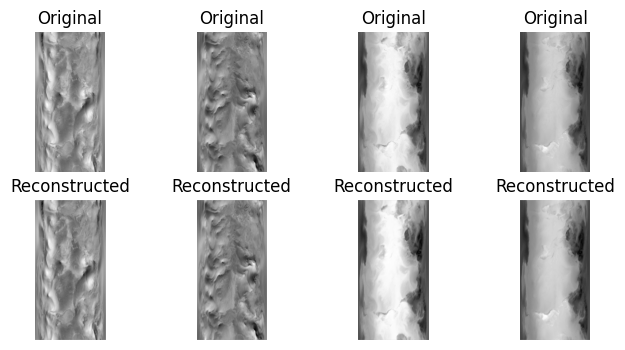

loss -  0.2971
[Test 2]


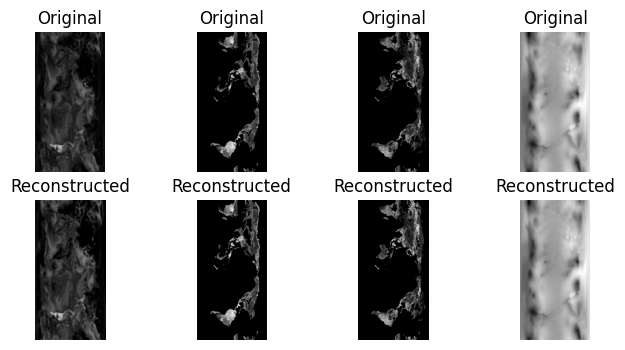

loss -  0.3896
[Test 3]


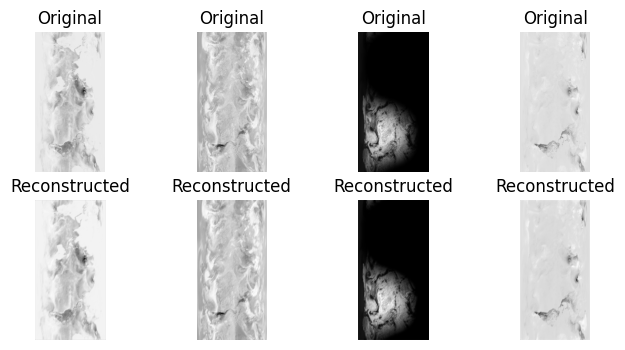

loss -  0.4205
[Test 4]


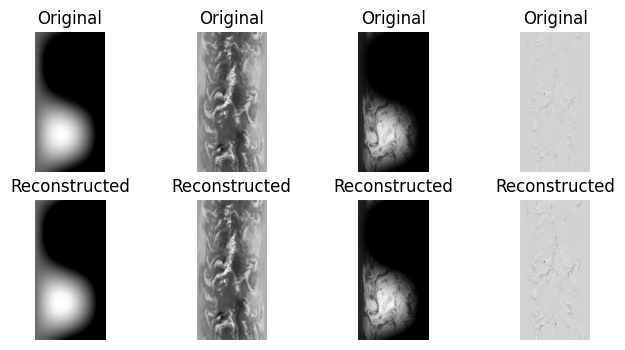

loss -  0.0834
[Test 5]


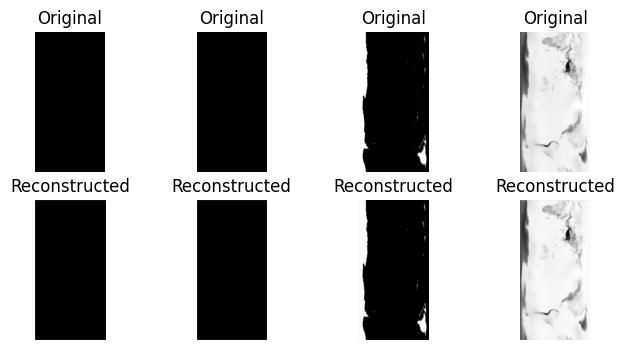

loss -  0.6107
[Test 1]


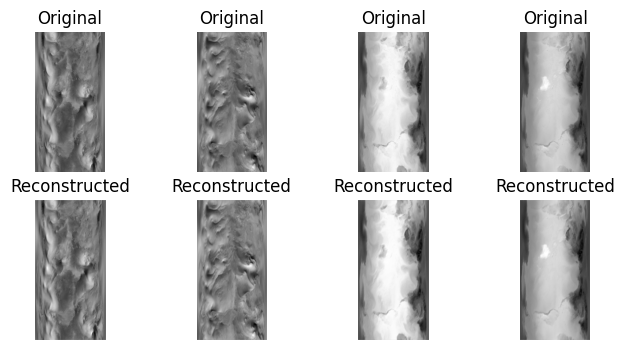

loss -  0.2969
[Test 2]


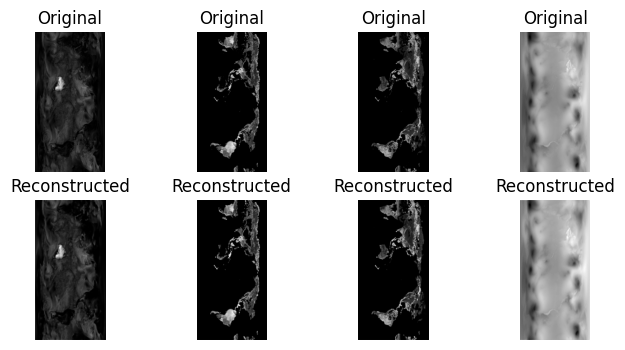

loss -  0.3889
[Test 3]


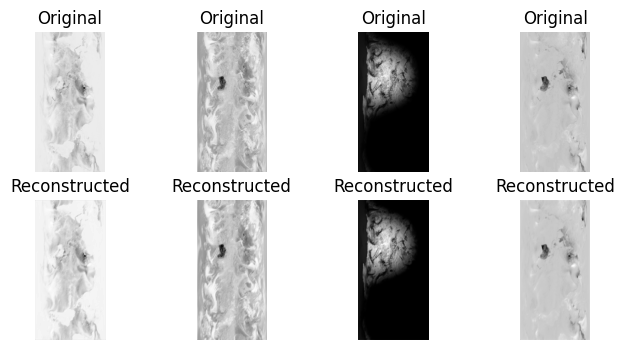

loss -  0.4210
[Test 4]


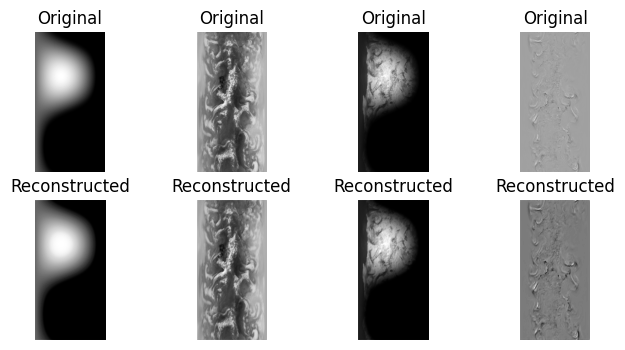

loss -  0.0836
[Test 5]


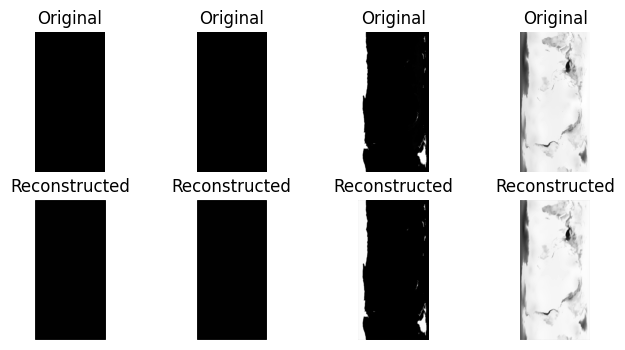

loss -  0.6107
[Test 1]


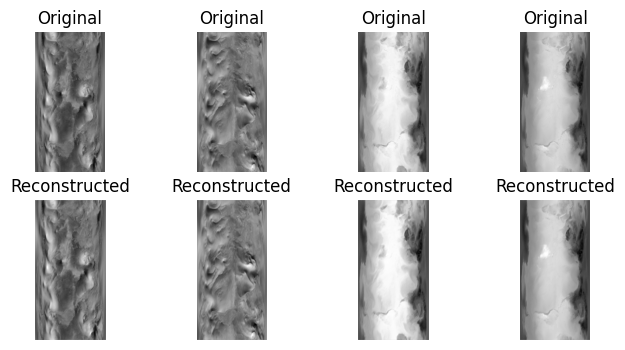

loss -  0.2953
[Test 2]


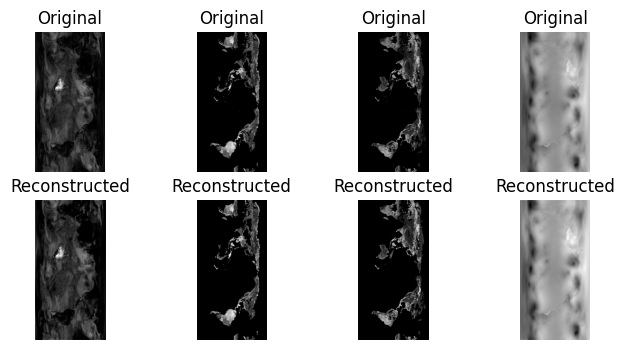

loss -  0.3862
[Test 3]


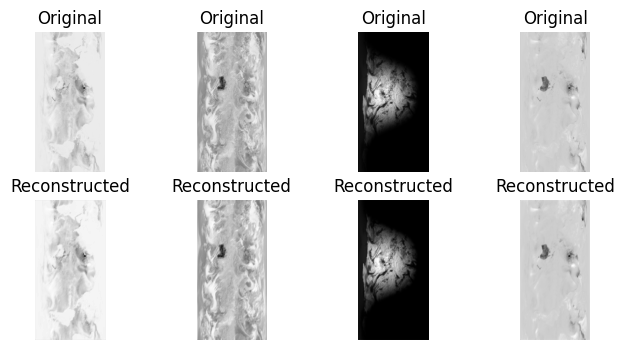

loss -  0.4206
[Test 4]


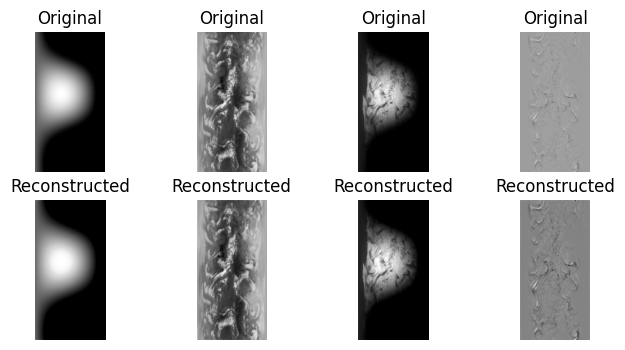

loss -  0.0836
[Test 5]


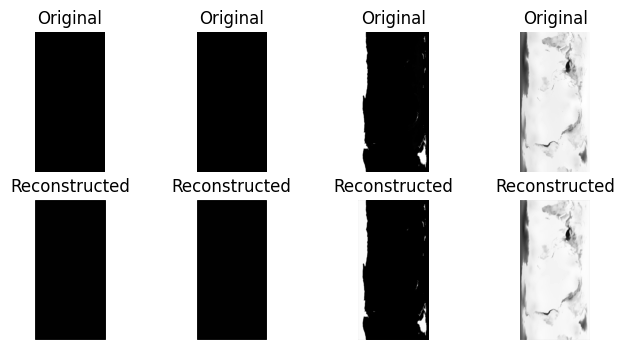

loss -  0.6089
[Test 1]


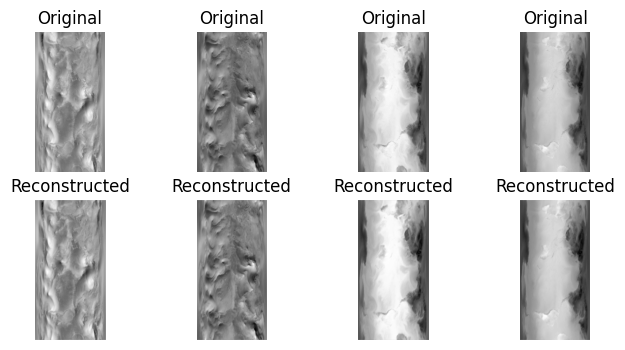

loss -  0.2991
[Test 2]


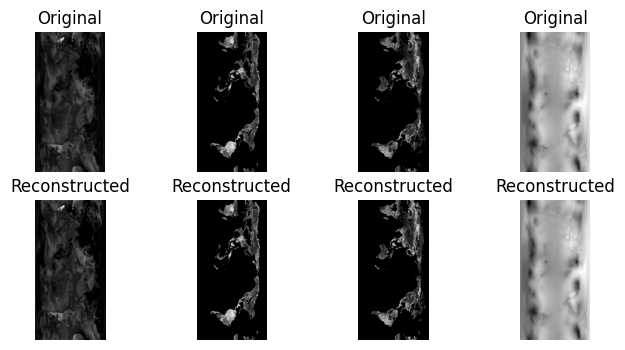

loss -  0.3912
[Test 3]


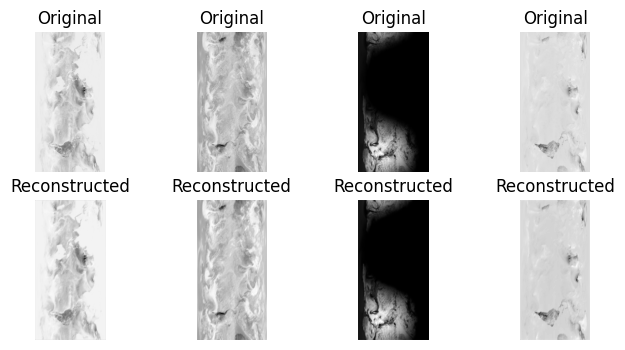

loss -  0.4207
[Test 4]


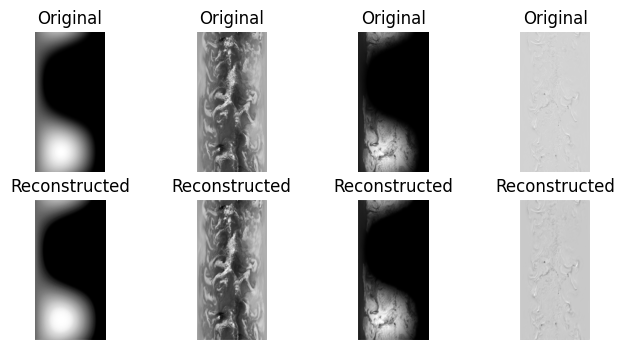

loss -  0.0834
[Test 5]


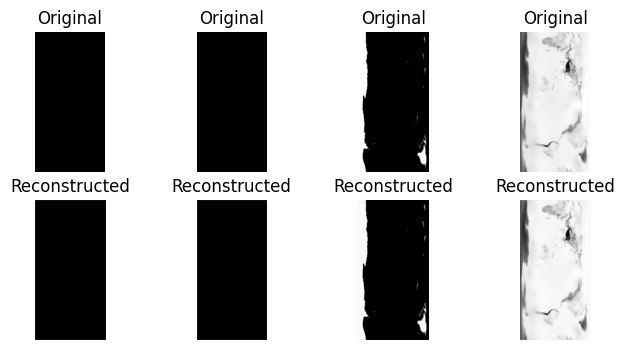

In [ ]:
import matplotlib.pyplot as plt

def visualize_reconstructions(model, criterion, data_loader, num_visualize=4):
    model.eval()

    with torch.no_grad():
        for i, (batch_X, time) in enumerate(data_loader):
            batch_X = batch_X.to(device).squeeze(0)
            batch_X = batch_X.view(7, -1, 1, batch_X.size(2), batch_X.size(3))
            for i, x in enumerate(batch_X):
                if i > num_visualize:
                    break
                x = x.to(device)
                outputs = model(x)
                loss = criterion(outputs, x)

                print(f"loss - {loss.item(): .4f}")

                # 시각적 비교 코드 (예시)
                plt.figure(figsize=(8, 4))

                print("[Test {}]".format(i+1))

                for j in range(x.size(0)):
                    plt.subplot(2, num_visualize, j + 1)
                    plt.imshow(x[j].squeeze().cpu().numpy(), cmap='gray')
                    plt.title('Original')
                    plt.axis('off')

                    plt.subplot(2, num_visualize, j + 1 + num_visualize)
                    plt.imshow(outputs[j].squeeze().cpu().numpy(), cmap='gray')
                    plt.title('Reconstructed')
                    plt.axis('off')

                plt.show()


visualize_reconstructions(model, criterion, valid_data_loader)


In [ ]:
del train_data_loader
del valid_data_loader
gc.collect()

77997